In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import pickle as pkl
from tensorflow import keras
import tensorflow.keras.backend as K
from keras.models import Sequential,Model
from keras.models import Sequential 
from keras.layers import Dense, Dropout, Flatten, Input, Reshape, BatchNormalization, Bidirectional, LSTM, Multiply, Activation, Normalization, TimeDistributed
from keras.layers import Conv3D, Conv2D, Conv1D, MaxPool3D, MaxPool2D, MaxPool1D, AvgPool3D, AvgPool2D, AvgPool1D, GlobalMaxPool3D, Attention, Subtract
from keras.layers import GlobalMaxPool2D, GlobalMaxPool1D, SpatialDropout3D, SpatialDropout2D, SpatialDropout1D, GlobalAvgPool3D, MultiHeadAttention
from keras.layers import GlobalAvgPool2D, GlobalAvgPool1D, SeparableConv2D, SeparableConv1D, Add, Concatenate, LeakyReLU, ELU, Activation, PReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from keras.utils import np_utils
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight
import gc

# **Data Loading**

In [2]:
from google.colab import drive
drive.mount('/content/drive/')
gc.collect()

Mounted at /content/drive/


81

In [3]:
input_path='/content/drive/MyDrive/data_preprocessed_python/'

In [5]:
def baseline_remove(XR):
  XT = XR[:, 384:]
  XB_ = (XR[:, :1*128] + XR[:, 1*128:2*128] + XR[:, 2*128:3*128])/3.0
  for i in range(60):
    XT[:, i*128:(i+1)*128] = XT[:, i*128:(i+1)*128] - XB_
  return XT


In [6]:
new_channels = [0,1,18,2,3,5,4,23,6,7,9,8,15,10,11,12,14,13,
 16,17,18,19,20,22,21,23,24,25,27,26,15,28,29,30,14,31]

In [7]:
eeg_signal = []
valence = []
arousal = []
window_size = 256
no_channels = 32
no_new_channels = len(new_channels)
no_videos = 40
Trsld = 5

for person in range(5,6):
  print('Person No.' + str(person))
  
  
  # EEG files address
  if person < 10 :
    address = input_path+'s0'+str(person)+'.dat'
  else :
    address = input_path+'s'+str(person)+'.dat'

  with open(address, 'rb') as file:
    data = pkl.load(file, encoding = 'latin1')

  eeg = data['data']
  label = data['labels']
  
  # Assigning classes
  label[label<Trsld] = 0
  label[label>=Trsld] = 1

  val = label.T[0] # Valence label
  aro = label.T[1] # Arousal label

  del data, label
  # Iterating through 40 vidoes/trials
  for i in range(no_videos):
    sig = eeg[i][:no_channels, :]
    sig = baseline_remove(sig)
    temp = []
    for j in new_channels:
      temp.append(sig[j, :])
    sig = np.reshape(temp,[no_new_channels,-1])
    # Segmenting into 2 seconds (256 timesteps) windows without overlap
    start = 0
    while start + window_size <=sig.shape[1]:
      eeg_signal.append(sig[:, start:start+window_size].T)
      valence.append(val[i])
      arousal.append(aro[i])
      start += window_size 
  del eeg, val, aro, sig
eeg_signal = np.reshape(eeg_signal,[-1,window_size,no_new_channels])
data = np.asarray(eeg_signal, dtype = np.float32) # Using 32 bit floating point value to save memory
del eeg_signal
valence = np.asarray(valence, dtype = np.int8)
arousal = np.asarray(arousal, dtype = np.int8)

print(data.shape)
print(valence.shape, valence[valence == 0].shape, valence[valence == 1].shape)
print(arousal.shape, arousal[arousal == 0].shape, arousal[arousal == 1].shape)

valence = np_utils.to_categorical(valence)
arousal = np_utils.to_categorical(arousal)
gc.collect()

Person No.5
(1200, 256, 36)
(1200,) (480,) (720,)
(1200,) (630,) (570,)


0

In [8]:
def simple_2D_CNN(x): 
  x = BatchNormalization()(x)
  x = Bidirectional(LSTM(32, return_sequences=True))(x)
  x = Bidirectional(LSTM(32, return_sequences=True))(x)
  x = Bidirectional(LSTM(32, return_sequences=True))(x)
  x = Bidirectional(LSTM(32, return_sequences=True))(x)
  x = Bidirectional(LSTM(32, return_sequences=False))(x)
  x = BatchNormalization()(x)
  x = Dropout(0.4)(x)
  x = Dense(32, activation='relu')(x)
  x = Dropout(0.1)(x)
  x = Dense(2, activation='softmax')(x)
  return x

def get_model(): 
  input_shape = (data.shape[1], data.shape[2]) 
  a = Input(input_shape) 
  out = simple_2D_CNN(a) 
  model = Model(a, out) 
  opt = keras.optimizers.Adam(learning_rate=1e-04) 
  model.compile(loss=keras.losses.categorical_crossentropy, metrics=["accuracy"], optimizer=opt) 
  return model 
model = get_model() 
model.summary() 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 36)]         0         
                                                                 
 batch_normalization (BatchN  (None, 256, 36)          144       
 ormalization)                                                   
                                                                 
 bidirectional (Bidirectiona  (None, 256, 64)          17664     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 256, 64)          24832     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 256, 64)          24832     
 nal)                                                        

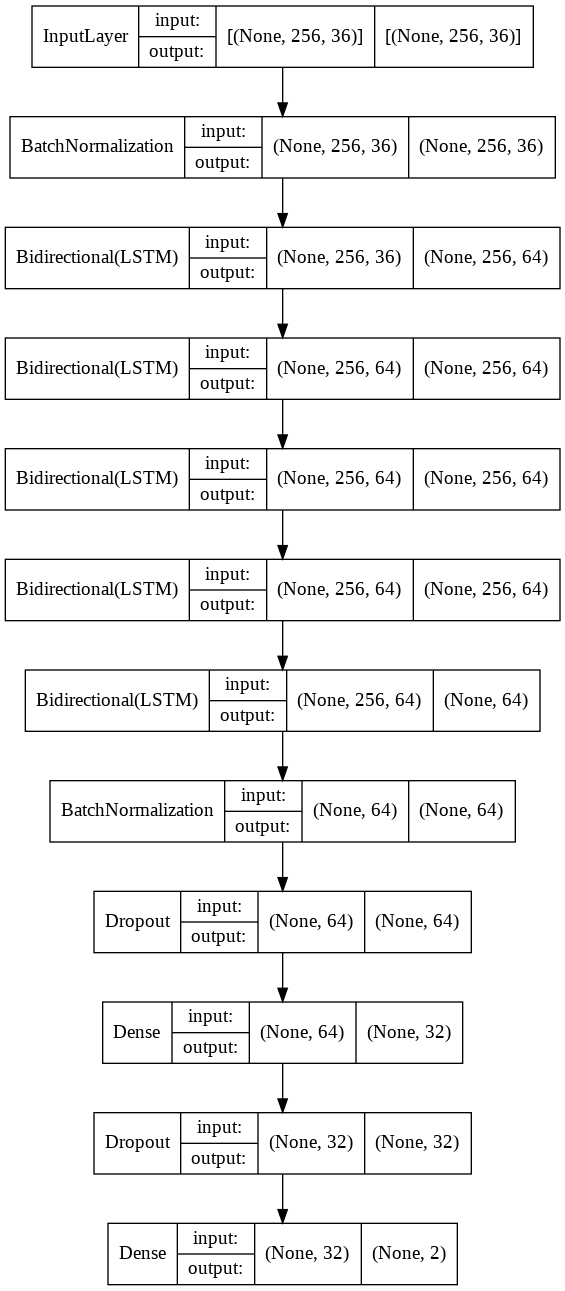

In [9]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=False)

In [10]:
batch_size = 64
epochs = 100
kfold = KFold(n_splits=10, random_state=1, shuffle=True)
gc.collect()

37895

In [11]:
def call_class_weights(yt):
  y_integers = np.argmax(yt, axis=1)
  class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(y_integers), y = y_integers)
  d_class_weights = dict(enumerate(class_weights))
  return d_class_weights

# **Arousal**

In [12]:
#arousal
X_train, x_test, Y_train, y_test = train_test_split(data,arousal, test_size=0.1, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(1080, 256, 36) (120, 256, 36) (1080, 2) (120, 2)


Results for fold 1
Epoch 1/100
16/16 [==============================] - 64s 2s/step - loss: 0.8481 - accuracy: 0.5422 - val_loss: 0.6839 - val_accuracy: 0.5648
Epoch 2/100
16/16 [==============================] - 23s 1s/step - loss: 0.7440 - accuracy: 0.5916 - val_loss: 0.6786 - val_accuracy: 0.7222
Epoch 3/100
16/16 [==============================] - 23s 1s/step - loss: 0.6880 - accuracy: 0.6142 - val_loss: 0.6767 - val_accuracy: 0.7037
Epoch 4/100
16/16 [==============================] - 22s 1s/step - loss: 0.6747 - accuracy: 0.6091 - val_loss: 0.6752 - val_accuracy: 0.7130
Epoch 5/100
16/16 [==============================] - 24s 1s/step - loss: 0.6301 - accuracy: 0.6749 - val_loss: 0.6729 - val_accuracy: 0.6944
Epoch 6/100
16/16 [==============================] - 23s 1s/step - loss: 0.6046 - accuracy: 0.6790 - val_loss: 0.6736 - val_accuracy: 0.6667
Epoch 7/100
16/16 [==============================] - 23s 1s/step - loss: 0.5864 - accuracy: 0.6944 - val_loss: 0.6715 - val_accuracy: 0

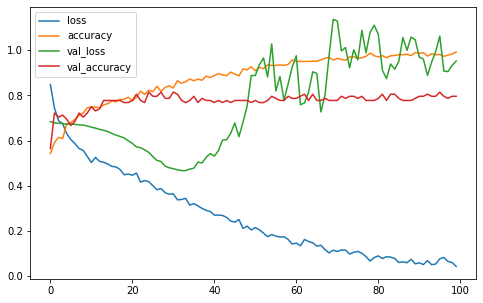

Results for fold 2
Epoch 1/100
16/16 [==============================] - 42s 2s/step - loss: 0.9678 - accuracy: 0.4825 - val_loss: 0.7012 - val_accuracy: 0.4444
Epoch 2/100
16/16 [==============================] - 20s 1s/step - loss: 0.8153 - accuracy: 0.5144 - val_loss: 0.6932 - val_accuracy: 0.4907
Epoch 3/100
16/16 [==============================] - 20s 1s/step - loss: 0.7271 - accuracy: 0.5638 - val_loss: 0.6881 - val_accuracy: 0.6296
Epoch 4/100
16/16 [==============================] - 21s 1s/step - loss: 0.6760 - accuracy: 0.5885 - val_loss: 0.6839 - val_accuracy: 0.6759
Epoch 5/100
16/16 [==============================] - 21s 1s/step - loss: 0.6649 - accuracy: 0.6019 - val_loss: 0.6811 - val_accuracy: 0.7037
Epoch 6/100
16/16 [==============================] - 21s 1s/step - loss: 0.6106 - accuracy: 0.6440 - val_loss: 0.6785 - val_accuracy: 0.7130
Epoch 7/100
16/16 [==============================] - 21s 1s/step - loss: 0.6018 - accuracy: 0.6790 - val_loss: 0.6762 - val_accuracy: 0

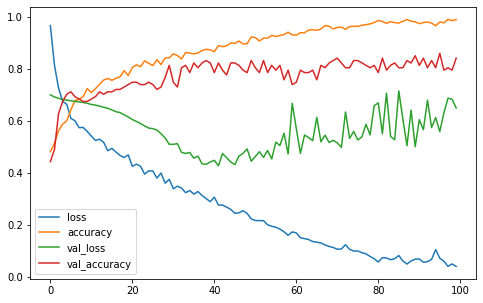

Results for fold 3
Epoch 1/100
16/16 [==============================] - 49s 2s/step - loss: 0.9974 - accuracy: 0.4846 - val_loss: 0.6923 - val_accuracy: 0.5185
Epoch 2/100
16/16 [==============================] - 21s 1s/step - loss: 0.8472 - accuracy: 0.5113 - val_loss: 0.6887 - val_accuracy: 0.5463
Epoch 3/100
16/16 [==============================] - 21s 1s/step - loss: 0.7406 - accuracy: 0.5597 - val_loss: 0.6880 - val_accuracy: 0.6019
Epoch 4/100
16/16 [==============================] - 22s 1s/step - loss: 0.7138 - accuracy: 0.5751 - val_loss: 0.6871 - val_accuracy: 0.6111
Epoch 5/100
16/16 [==============================] - 22s 1s/step - loss: 0.6611 - accuracy: 0.6152 - val_loss: 0.6858 - val_accuracy: 0.6019
Epoch 6/100
16/16 [==============================] - 21s 1s/step - loss: 0.6631 - accuracy: 0.6132 - val_loss: 0.6856 - val_accuracy: 0.5741
Epoch 7/100
16/16 [==============================] - 22s 1s/step - loss: 0.6147 - accuracy: 0.6523 - val_loss: 0.6850 - val_accuracy: 0

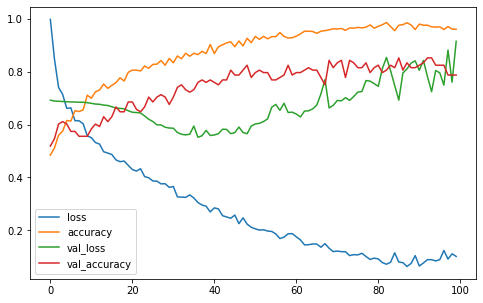

Results for fold 4
Epoch 1/100
16/16 [==============================] - 53s 2s/step - loss: 0.7913 - accuracy: 0.5195 - val_loss: 0.6889 - val_accuracy: 0.5556
Epoch 2/100
16/16 [==============================] - 24s 1s/step - loss: 0.7134 - accuracy: 0.5833 - val_loss: 0.6875 - val_accuracy: 0.5741
Epoch 3/100
16/16 [==============================] - 27s 2s/step - loss: 0.6571 - accuracy: 0.6327 - val_loss: 0.6871 - val_accuracy: 0.5741
Epoch 4/100
16/16 [==============================] - 27s 2s/step - loss: 0.6197 - accuracy: 0.6698 - val_loss: 0.6852 - val_accuracy: 0.6019
Epoch 5/100
16/16 [==============================] - 26s 2s/step - loss: 0.6047 - accuracy: 0.6831 - val_loss: 0.6830 - val_accuracy: 0.6111
Epoch 6/100
16/16 [==============================] - 31s 2s/step - loss: 0.5720 - accuracy: 0.7078 - val_loss: 0.6808 - val_accuracy: 0.5926
Epoch 7/100
16/16 [==============================] - 26s 2s/step - loss: 0.5599 - accuracy: 0.7202 - val_loss: 0.6789 - val_accuracy: 0

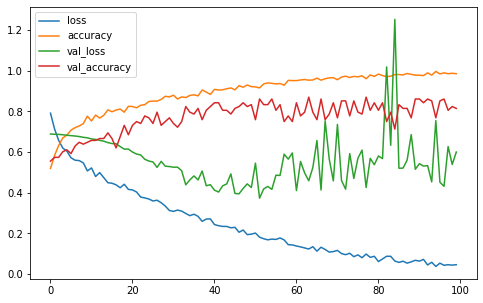

Results for fold 5
Epoch 1/100
16/16 [==============================] - 55s 2s/step - loss: 0.8797 - accuracy: 0.5206 - val_loss: 0.6837 - val_accuracy: 0.6204
Epoch 2/100
16/16 [==============================] - 21s 1s/step - loss: 0.7667 - accuracy: 0.5802 - val_loss: 0.6829 - val_accuracy: 0.6111
Epoch 3/100
16/16 [==============================] - 21s 1s/step - loss: 0.6837 - accuracy: 0.6235 - val_loss: 0.6832 - val_accuracy: 0.5556
Epoch 4/100
16/16 [==============================] - 22s 1s/step - loss: 0.6356 - accuracy: 0.6636 - val_loss: 0.6822 - val_accuracy: 0.5741
Epoch 5/100
16/16 [==============================] - 24s 2s/step - loss: 0.6086 - accuracy: 0.6914 - val_loss: 0.6793 - val_accuracy: 0.5833
Epoch 6/100
16/16 [==============================] - 22s 1s/step - loss: 0.5816 - accuracy: 0.7078 - val_loss: 0.6788 - val_accuracy: 0.5833
Epoch 7/100
16/16 [==============================] - 21s 1s/step - loss: 0.5770 - accuracy: 0.7233 - val_loss: 0.6773 - val_accuracy: 0

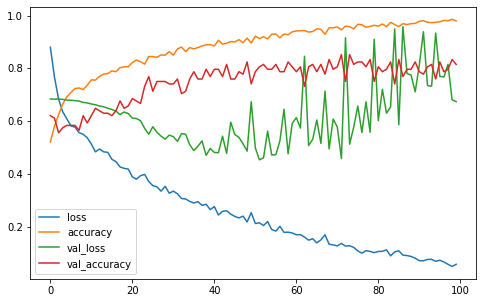

Results for fold 6
Epoch 1/100
16/16 [==============================] - 47s 2s/step - loss: 0.7968 - accuracy: 0.5247 - val_loss: 0.6870 - val_accuracy: 0.6574
Epoch 2/100
16/16 [==============================] - 22s 1s/step - loss: 0.6944 - accuracy: 0.5936 - val_loss: 0.6849 - val_accuracy: 0.6759
Epoch 3/100
16/16 [==============================] - 22s 1s/step - loss: 0.6805 - accuracy: 0.6080 - val_loss: 0.6826 - val_accuracy: 0.6852
Epoch 4/100
16/16 [==============================] - 23s 1s/step - loss: 0.6311 - accuracy: 0.6523 - val_loss: 0.6811 - val_accuracy: 0.6667
Epoch 5/100
16/16 [==============================] - 23s 1s/step - loss: 0.6065 - accuracy: 0.6893 - val_loss: 0.6794 - val_accuracy: 0.7593
Epoch 6/100
16/16 [==============================] - 22s 1s/step - loss: 0.5888 - accuracy: 0.6811 - val_loss: 0.6760 - val_accuracy: 0.7685
Epoch 7/100
16/16 [==============================] - 23s 1s/step - loss: 0.5966 - accuracy: 0.6811 - val_loss: 0.6729 - val_accuracy: 0

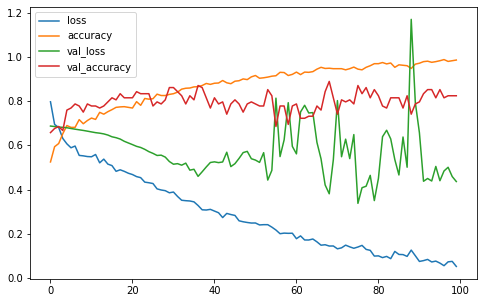

Results for fold 7
Epoch 1/100
16/16 [==============================] - 48s 2s/step - loss: 0.7983 - accuracy: 0.5514 - val_loss: 0.6868 - val_accuracy: 0.5370
Epoch 2/100
16/16 [==============================] - 22s 1s/step - loss: 0.7236 - accuracy: 0.5926 - val_loss: 0.6843 - val_accuracy: 0.5556
Epoch 3/100
16/16 [==============================] - 23s 1s/step - loss: 0.6888 - accuracy: 0.5957 - val_loss: 0.6830 - val_accuracy: 0.5556
Epoch 4/100
16/16 [==============================] - 22s 1s/step - loss: 0.6576 - accuracy: 0.6502 - val_loss: 0.6809 - val_accuracy: 0.6204
Epoch 5/100
16/16 [==============================] - 22s 1s/step - loss: 0.6410 - accuracy: 0.6512 - val_loss: 0.6785 - val_accuracy: 0.6481
Epoch 6/100
16/16 [==============================] - 22s 1s/step - loss: 0.6162 - accuracy: 0.6687 - val_loss: 0.6763 - val_accuracy: 0.6667
Epoch 7/100
16/16 [==============================] - 22s 1s/step - loss: 0.6146 - accuracy: 0.6790 - val_loss: 0.6736 - val_accuracy: 0

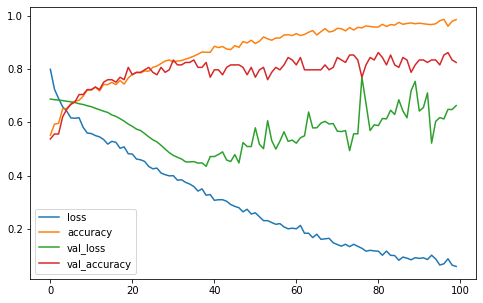

Results for fold 8
Epoch 1/100
16/16 [==============================] - 51s 2s/step - loss: 0.8271 - accuracy: 0.5473 - val_loss: 0.6934 - val_accuracy: 0.4630
Epoch 2/100
16/16 [==============================] - 22s 1s/step - loss: 0.7211 - accuracy: 0.5844 - val_loss: 0.6871 - val_accuracy: 0.5463
Epoch 3/100
16/16 [==============================] - 21s 1s/step - loss: 0.6716 - accuracy: 0.6471 - val_loss: 0.6832 - val_accuracy: 0.6389
Epoch 4/100
16/16 [==============================] - 22s 1s/step - loss: 0.6512 - accuracy: 0.6718 - val_loss: 0.6796 - val_accuracy: 0.6574
Epoch 5/100
16/16 [==============================] - 22s 1s/step - loss: 0.6083 - accuracy: 0.6955 - val_loss: 0.6756 - val_accuracy: 0.6944
Epoch 6/100
16/16 [==============================] - 22s 1s/step - loss: 0.5853 - accuracy: 0.7284 - val_loss: 0.6706 - val_accuracy: 0.7130
Epoch 7/100
16/16 [==============================] - 21s 1s/step - loss: 0.5732 - accuracy: 0.7274 - val_loss: 0.6677 - val_accuracy: 0

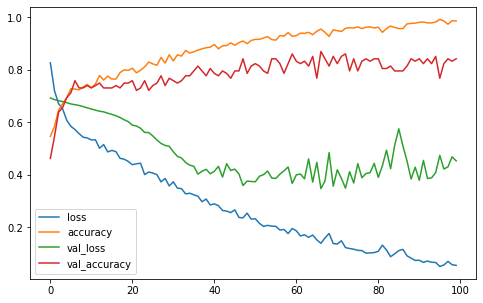

Results for fold 9
Epoch 1/100
16/16 [==============================] - 50s 2s/step - loss: 0.8697 - accuracy: 0.5185 - val_loss: 0.6869 - val_accuracy: 0.5741
Epoch 2/100
16/16 [==============================] - 21s 1s/step - loss: 0.7940 - accuracy: 0.5381 - val_loss: 0.6831 - val_accuracy: 0.7037
Epoch 3/100
16/16 [==============================] - 21s 1s/step - loss: 0.7453 - accuracy: 0.5669 - val_loss: 0.6799 - val_accuracy: 0.7315
Epoch 4/100
16/16 [==============================] - 21s 1s/step - loss: 0.7217 - accuracy: 0.5844 - val_loss: 0.6766 - val_accuracy: 0.6944
Epoch 5/100
16/16 [==============================] - 22s 1s/step - loss: 0.6510 - accuracy: 0.6379 - val_loss: 0.6737 - val_accuracy: 0.6574
Epoch 6/100
16/16 [==============================] - 20s 1s/step - loss: 0.6733 - accuracy: 0.6173 - val_loss: 0.6709 - val_accuracy: 0.6852
Epoch 7/100
16/16 [==============================] - 21s 1s/step - loss: 0.6466 - accuracy: 0.6348 - val_loss: 0.6692 - val_accuracy: 0

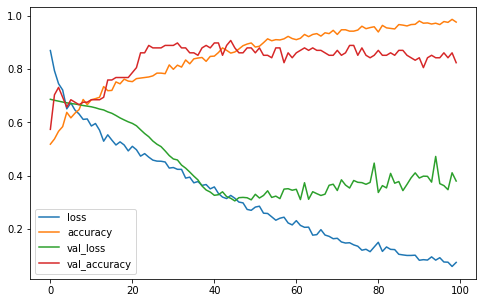

Results for fold 10
Epoch 1/100
16/16 [==============================] - 44s 2s/step - loss: 0.8345 - accuracy: 0.4949 - val_loss: 0.6909 - val_accuracy: 0.5278
Epoch 2/100
16/16 [==============================] - 20s 1s/step - loss: 0.7523 - accuracy: 0.5278 - val_loss: 0.6873 - val_accuracy: 0.7037
Epoch 3/100
16/16 [==============================] - 20s 1s/step - loss: 0.7071 - accuracy: 0.5514 - val_loss: 0.6847 - val_accuracy: 0.6944
Epoch 4/100
16/16 [==============================] - 20s 1s/step - loss: 0.6613 - accuracy: 0.6142 - val_loss: 0.6822 - val_accuracy: 0.6759
Epoch 5/100
16/16 [==============================] - 20s 1s/step - loss: 0.6345 - accuracy: 0.5947 - val_loss: 0.6797 - val_accuracy: 0.6204
Epoch 6/100
16/16 [==============================] - 20s 1s/step - loss: 0.6121 - accuracy: 0.6214 - val_loss: 0.6775 - val_accuracy: 0.6296
Epoch 7/100
16/16 [==============================] - 20s 1s/step - loss: 0.6009 - accuracy: 0.6667 - val_loss: 0.6750 - val_accuracy: 

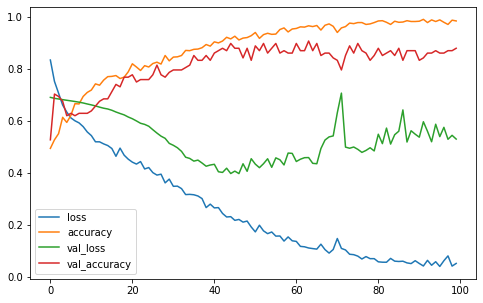

In [13]:
val_res = {'accuracy': [], 'f1_score': [], 'confusion_matrix': []}
foldNum=0
#model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  model = get_model()
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  class_weight = call_class_weights(y_train)
  history = model.fit(x_train, y_train, epochs=epochs, class_weight=class_weight, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  acc = model.evaluate(x_test, y_test)
  print(acc)
  val_res['accuracy'].append(acc)
  pred = model.predict(x_test)
  f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
  print(f1scr)
  pd.DataFrame(history.history).plot(figsize=(8,5))
  plt.show()
  val_res['f1_score'].append(f1scr)
  val_res['confusion_matrix'].append(confusion_matrix(y_test.argmax(1), pred.argmax(1)))
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val, acc, f1scr
  gc.collect()

Accuracy  : 0.8791666626930237
F1_Score  : 0.8782178227731355


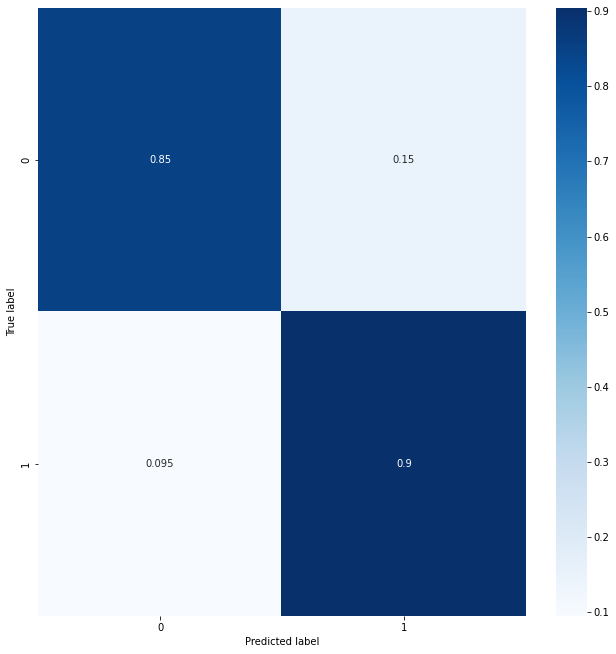

In [14]:
acrc = np.array(val_res['accuracy']).mean(axis=0)
f1scr = np.array(val_res['f1_score']).mean(axis=0)
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
cmatrix = np.array(val_res['confusion_matrix']).mean(axis=0)
c_matrix = cmatrix/np.sum(cmatrix, axis=1).reshape(2,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()